In [1]:
import warnings
#warnings.filterwarnings('ignore')

In [2]:
import os
import pyspark
from pyspark.sql import SparkSession, functions as F
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
from lifelines import CoxPHFitter, WeibullAFTFitter

os.environ["SPARK_HOME"] = pyspark.__path__[0]
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"
os.environ["PYSPARK_PYTHON"] = "python"

spark = (
    SparkSession.builder
    .config("spark.driver.memory", "8g")
    .getOrCreate()
)

In [3]:
levels = spark.read.csv("../data/20210801_all_levels.csv", header=True, inferSchema=True).cache()
levels.createOrReplaceTempView("levels")
levels.printSchema()

ranking = spark.read.csv("../data/20210801_all_ranking.csv", header=True, inferSchema=True).cache()
ranking.createOrReplaceTempView("ranking")
ranking.printSchema()

exptable = spark.read.csv("../data/exptable.csv", header=True, inferSchema=True).cache()
exptable.createOrReplaceTempView("exptable")
exptable.printSchema()

root
 |-- level: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- timestamp: string (nullable = true)

root
 |-- name: string (nullable = true)
 |-- level: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- specialization: string (nullable = true)
 |-- mastery: string (nullable = true)
 |-- fame: integer (nullable = true)
 |-- guild: string (nullable = true)
 |-- rank: integer (nullable = true)

root
 |-- level: integer (nullable = true)
 |-- exp: integer (nullable = true)
 |-- cumulative_exp: long (nullable = true)



In [32]:
def get_df(level, field="exp_per_time"):
    diff = """
    (unix_timestamp(from_utc_timestamp("2021-08-01", "Z")) 
    - unix_timestamp(from_utc_timestamp(last_ts, "Z")))/60
    """
    exp = spark.sql("select * from exptable").collect()
    d = {row.level: row.exp for row in exp}
    pivot_expr = ",".join(
        [
            f"""
                min(if(level=={i}, {field}, null)) 
                as ttl_{i}
            """
            for i in range(3, level)
            if i >= level - 10
        ]
    )

    df = spark.sql(f"""
    with jobs as (
        select name, job
        from ranking
    ),
    ttl as (
        select
            name,
            job,
            level,
            first(timestamp) over (partition by name order by level) as first_ts,
            lag(timestamp) over (partition by name order by level) as last_ts,
            (unix_timestamp(from_utc_timestamp(timestamp, "Z"))
                - unix_timestamp(from_utc_timestamp(lag(timestamp) over (partition by name order by level), "Z")))/60
                as time,
            exp/(unix_timestamp(from_utc_timestamp(timestamp, "Z"))
                - unix_timestamp(from_utc_timestamp(lag(timestamp) over (partition by name order by level), "Z")))/60
                as exp_per_time
        from levels
        join jobs
        using (name)
        join exptable
        using (level)
    ),
    pivoted as (
        select
            name,
            job,
            max(level) as max_level,
            min(if(level={level} and time is not null, time, {diff})) as duration,
            max(if(level={level}, 1, 0)) as observed,
            {pivot_expr}
        from ttl
        group by name, job
    )
    select * from pivoted
    where
        duration >=0
        and max_level >= {level-1}
    """)
    return df.toPandas()

df = get_df(175)

In [33]:
df

,name,job,max_level,duration,observed,ttl_165,ttl_166,ttl_167,ttl_168,ttl_169,ttl_170,ttl_171,ttl_172,ttl_173,ttl_174
0,BushyBrows,magician,176,4487.666667,1,15.985073,2.885398,2.428372,32.698585,19.426056,42.012803,5.184703,0.751805,1.180786,2.130359
1,Expert,bowman,175,8531.966667,1,20.961179,1.148688,1.304498,5.640114,1.555677,2.962004,1.560474,1.042577,48.655272,9.504833
2,Heaven,warrior,200,5544.366667,1,51.942825,33.163632,17.409702,18.349723,10.301280,65.455741,28.412271,47.041375,24.215058,25.185912
3,Helmut,magician,176,15583.700000,1,49.969471,30.255910,17.977808,33.724608,45.535721,44.682284,25.921818,30.121089,26.341226,19.865223
4,JollyWalker,magician,178,158075.050000,1,10.253211,13.131374,14.417166,17.924238,26.628628,28.793562,21.542150,24.439181,13.171027,21.036886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424,CauTionNL,thief,182,9553.133333,1,26.567998,16.689185,15.294962,17.280846,19.924619,8.370775,17.696591,14.155870,8.481990,18.631279
1425,JayChou,magician,200,10542.266667,1,28.719306,35.197977,24.170966,66.877284,92.412850,100.607129,8.476201,32.392718,44.133137,27.453141
1426,ReidoGado,magician,200,1508.916667,1,38.625715,33.673639,24.792605,72.589571,60.443544,71.710111,25.055617,84.356016,47.867754,37.053683
1427,lxXxI,thief,187,6947.533333,1,12.386870,16.993902,22.205331,24.841652,19.775887,26.787090,29.168877,25.187313,18.166114,16.674811


In [16]:
df.observed.sum(), df.shape

(1338, (1429, 15))

<AxesSubplot:>

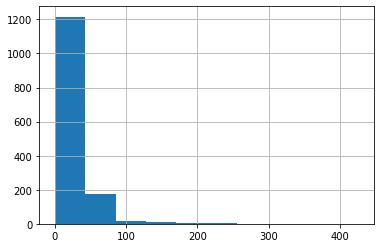

In [17]:
df.ttl_165.hist()

(array([  2.,   5.,  14.,  41., 142., 408., 462., 301.,  41.,  10.]),
 array([-2.70712587, -1.83078414, -0.95444241, -0.07810069,  0.79824104,
         1.67458277,  2.5509245 ,  3.42726623,  4.30360795,  5.17994968,
         6.05629141]),
 <BarContainer object of 10 artists>)

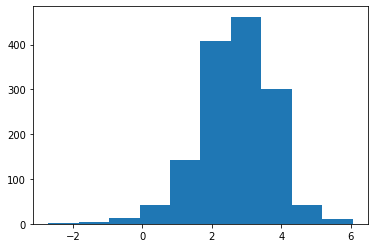

In [18]:
plt.hist(np.log(df.ttl_165))

# in-sample comparison of different models

In [37]:
df = get_df(180)

In [44]:
def transform(df, log=False):
    z = df.drop(columns=["name", "job", "max_level"]).copy()
    if log:
        cols = [c for c in z.columns if c.startswith("ttl") or c == "age"]
        for col in cols:
            z[col] = np.log(z[col])
    return z[~z.isnull().any(axis=1)]

In [45]:
cph = CoxPHFitter().fit(transform(df, True), duration_col="duration", event_col="observed")

In [46]:
cph.AIC_partial_

11309.262727055

In [48]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1025 total observations, 59 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 1025
number of events observed = 966
   partial log-likelihood = -5644.63
         time fit was run = 2021-08-15 04:59:58 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
ttl_170    -0.04       0.96       0.04            -0.12             0.04                 0.89                 1.04
ttl_171     0.05       1.05       0.05            -0.04             0.14                 0.96                 1.15
ttl_172    -0.01       0.99       0.05            -0.10             0.08                 0.91                 1.08
ttl_173     0.03       1.03       0.04            -0.05             0.12                 0.95                 1.13
ttl_174    -0.07       0.93       0.05            -0.16             0.02                 0.85                 1.02
ttl_175     0.15       1.17       0.04             0.07             0.24                 1.08                 1.27
ttl_176     0.07       1.07       0.04            -0.02             0.15                 0.98                 1.16
ttl_177     0.12       1.12       0.04             0.03             0.20                 1.03                 1.22
ttl_178     0.14       1.15       0.05             0.05             0.23                 1.05                 1.25
ttl_179     0.48       1.62       0.04             0.40             0.57                 1.49                 1.76

              z      p   -log2(p)
covariate                        
ttl_170   -0.99   0.32       1.64
ttl_171    1.12   0.26       1.92
ttl_172   -0.25   0.80       0.31
ttl_173    0.73   0.47       1.10
ttl_174   -1.62   0.11       3.24
ttl_175    3.76 <0.005      12.52
ttl_176    1.53   0.13       3.00
ttl_177    2.68   0.01       7.06
ttl_178    3.03 <0.005       8.68
ttl_179   11.22 <0.005      94.60
---
Concordance = 0.75
Partial AIC = 11309.26
log-likelihood ratio test = 437.70 on 10 df
-log2(p) of ll-ratio test = 289.20

In [14]:
for cph in [cph1, cph2, cph3, cph4]:
    print(f"aic: {cph.AIC_partial_}")

aic: 11560.684924517518
aic: 11309.26298955611
aic: 11383.190899434145
aic: 11308.935167475034


In [15]:
cph4.print_summary()

<lifelines.CoxPHFitter: fitted with 1025 total observations, 59 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 1025
number of events observed = 966
   partial log-likelihood = -5644.47
         time fit was run = 2021-08-14 18:34:56 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
ttl_170    -0.04       0.96       0.04            -0.12             0.04                 0.89                 1.04
ttl_171     0.05       1.05       0.05            -0.04             0.14                 0.96                 1.15
ttl_172    -0.01       0.99       0.05            -0.10             0.08                 0.91                 1.08
ttl_173     0.03       1.03       0.04            -0.06             0.12                 0.95                 1.13
ttl_174    -0.07       0.93       0.05            -0.16             0.02                 0.85                 1.02
ttl_175     0.16       1.17       0.04             0.07             0.24                 1.08                 1.27
ttl_176     0.07       1.07       0.04            -0.02             0.15                 0.98                 1.16
ttl_177     0.12       1.12       0.04             0.03             0.20                 1.03                 1.23
ttl_178     0.14       1.15       0.05             0.05             0.23                 1.05                 1.25
ttl_179     0.48       1.62       0.04             0.40             0.57                 1.49                 1.77

              z      p   -log2(p)
covariate                        
ttl_170   -1.00   0.32       1.65
ttl_171    1.11   0.27       1.91
ttl_172   -0.24   0.81       0.30
ttl_173    0.72   0.47       1.08
ttl_174   -1.62   0.11       3.24
ttl_175    3.76 <0.005      12.55
ttl_176    1.52   0.13       2.97
ttl_177    2.67   0.01       7.06
ttl_178    3.03 <0.005       8.66
ttl_179   11.23 <0.005      94.80
---
Concordance = 0.75
Partial AIC = 11308.94
log-likelihood ratio test = 438.03 on 10 df
-log2(p) of ll-ratio test = 289.43

## ph vs aft

In [17]:
cph = CoxPHFitter().fit(transform(df_norm, True), duration_col="duration", event_col="observed")
aft = WeibullAFTFitter().fit(transform(df_norm, True), duration_col="duration", event_col="observed")

print(f"cph concordance: {cph.concordance_index_}")
print(f"aft concordance: {aft.concordance_index_}")

cph concordance: 0.7492594155887959
aft concordance: 0.7463548984575414


In [18]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1025 total observations, 59 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 1025
number of events observed = 966
   partial log-likelihood = -5644.47
         time fit was run = 2021-08-14 18:36:45 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
ttl_170    -0.04       0.96       0.04            -0.12             0.04                 0.89                 1.04
ttl_171     0.05       1.05       0.05            -0.04             0.14                 0.96                 1.15
ttl_172    -0.01       0.99       0.05            -0.10             0.08                 0.91                 1.08
ttl_173     0.03       1.03       0.04            -0.06             0.12                 0.95                 1.13
ttl_174    -0.07       0.93       0.05            -0.16             0.02                 0.85                 1.02
ttl_175     0.16       1.17       0.04             0.07             0.24                 1.08                 1.27
ttl_176     0.07       1.07       0.04            -0.02             0.15                 0.98                 1.16
ttl_177     0.12       1.12       0.04             0.03             0.20                 1.03                 1.23
ttl_178     0.14       1.15       0.05             0.05             0.23                 1.05                 1.25
ttl_179     0.48       1.62       0.04             0.40             0.57                 1.49                 1.77

              z      p   -log2(p)
covariate                        
ttl_170   -1.00   0.32       1.65
ttl_171    1.11   0.27       1.91
ttl_172   -0.24   0.81       0.30
ttl_173    0.72   0.47       1.08
ttl_174   -1.62   0.11       3.24
ttl_175    3.76 <0.005      12.55
ttl_176    1.52   0.13       2.97
ttl_177    2.67   0.01       7.06
ttl_178    3.03 <0.005       8.66
ttl_179   11.23 <0.005      94.80
---
Concordance = 0.75
Partial AIC = 11308.94
log-likelihood ratio test = 438.03 on 10 df
-log2(p) of ll-ratio test = 289.43

In [19]:
aft.print_summary()

<lifelines.WeibullAFTFitter: fitted with 1025 total observations, 59 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
   number of observations = 1025
number of events observed = 966
           log-likelihood = -14764.73
         time fit was run = 2021-08-14 18:36:45 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                         
lambda_ ttl_170     0.08       1.08       0.06            -0.03             0.19                 0.97                 1.21
        ttl_171    -0.03       0.97       0.07            -0.16             0.10                 0.85                 1.10
        ttl_172    -0.06       0.94       0.06            -0.19             0.06                 0.83                 1.06
        ttl_173    -0.09       0.91       0.06            -0.21             0.02                 0.81                 1.02
        ttl_174     0.17       1.19       0.06             0.06             0.28                 1.06                 1.33
        ttl_175    -0.17       0.84       0.06            -0.28            -0.06                 0.75                 0.94
        ttl_176    -0.05       0.95       0.06            -0.16             0.07                 0.85                 1.07
        ttl_177    -0.14       0.87       0.06            -0.27            -0.02                 0.77                 0.98
        ttl_178    -0.13       0.87       0.06            -0.26            -0.01                 0.77                 0.99
        ttl_179    -0.57       0.57       0.05            -0.67            -0.46                 0.51                 0.63
        Intercept  21.08   1.43e+09       0.46            20.17            21.98             5.78e+08             3.52e+09
rho_    Intercept  -0.36       0.70       0.02            -0.40            -0.32                 0.67                 0.73

                       z      p   -log2(p)
param   covariate                         
lambda_ ttl_170     1.37   0.17       2.54
        ttl_171    -0.47   0.64       0.64
        ttl_172    -1.00   0.32       1.65
        ttl_173    -1.59   0.11       3.17
        ttl_174     2.92 <0.005       8.16
        ttl_175    -3.06 <0.005       8.84
        ttl_176    -0.78   0.43       1.20
        ttl_177    -2.27   0.02       5.43
        ttl_178    -2.17   0.03       5.07
        ttl_179   -10.69 <0.005      86.16
        Intercept  45.74 <0.005        inf
rho_    Intercept -18.07 <0.005     240.14
---
Concordance = 0.75
AIC = 29553.45
log-likelihood ratio test = 375.24 on 10 df
-log2(p) of ll-ratio test = 245.03

## penalties

In [155]:
from scipy.stats import loguniform

p = loguniform.rvs(1e-3, 1e0, size=100)
l1 = np.random.rand(100)

In [158]:
list(zip(p, l1))[:5]

[(0.0012788785470971358, 0.12742878648506617),
 (0.09019690789772537, 0.928191183592385),
 (0.028592301681138143, 0.9439269874708662),
 (0.21510996481932404, 0.8272258847601431),
 (0.009534907220185643, 0.4721117586096303)]

In [161]:
res = []
for penalizer, l1_ratio in [[0,0], *list(zip(p, l1))]:
    cph = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio).fit(
        transform(df_norm, True), 
        duration_col="duration", 
        event_col="observed"
    )
    print(f"p: {penalizer:.4f}\tl1 ratio: {l1_ratio:.4f}\taic: {cph.AIC_partial_}")
    res.append(dict(aic=cph.AIC_partial_, p=penalizer, l1=l1_ratio))

p: 0.0000	l1 ratio: 0.0000	aic: 20756.375317352864
p: 0.0013	l1 ratio: 0.1274	aic: 20757.720481014894
p: 0.0902	l1 ratio: 0.9282	aic: 21003.535073800413
p: 0.0286	l1 ratio: 0.9439	aic: 20849.653643143458
p: 0.2151	l1 ratio: 0.8272	aic: 21201.889532110898
p: 0.0095	l1 ratio: 0.4721	aic: 20777.427744340894
p: 0.0321	l1 ratio: 0.0521	aic: 20780.380295308492
p: 0.0012	l1 ratio: 0.4995	aic: 20759.30579250059
p: 0.0263	l1 ratio: 0.7155	aic: 20828.254761777283
p: 0.8946	l1 ratio: 0.5667	aic: 21456.85113920379
p: 0.8564	l1 ratio: 0.8253	aic: 21458.08253322146
p: 0.0141	l1 ratio: 0.0196	aic: 20765.59252314855
p: 0.6231	l1 ratio: 0.9941	aic: 21458.081620957742
p: 0.0082	l1 ratio: 0.3034	aic: 20769.83926280832
p: 0.0869	l1 ratio: 0.8435	aic: 20980.96868712405
p: 0.5783	l1 ratio: 0.4664	aic: 21353.27477417643
p: 0.4167	l1 ratio: 0.8185	aic: 21389.07592702352
p: 0.3063	l1 ratio: 0.7153	aic: 21272.197775354427
p: 0.0735	l1 ratio: 0.7965	aic: 20943.741688608225
p: 0.0225	l1 ratio: 0.6754	aic: 20816.6

In [166]:
pd.DataFrame(res).sort_values(by="aic")

,aic,p,l1
0,20756.375317,0.000000,0.000000
1,20757.720481,0.001279,0.127429
49,20757.759725,0.001884,0.038653
77,20758.260107,0.001040,0.340879
73,20758.311818,0.001011,0.369961
...,...,...,...
51,21458.081590,0.775609,0.788826
12,21458.081621,0.623070,0.994140
72,21458.082225,0.994286,0.648599
54,21458.082432,0.813698,0.843211
